# Transfer Learning

![tranfer_inner_chi](assets/transfer/transfer_inner_chi.jpg)

(image: kuailexiaorongrong.blog.163.com, via https://sg.news.yahoo.com/6-kungfu-moves-movies-wished-194241611.html)

# Topics

- Introduction & motivation
- Adapting Neural Networks
- Process

# Transfer Learning

Transfering the knowledge of one model to perform a new task.

"Domain Adaptation"

## Motivation

- Lots of data, time, resources needed to train and tune a neural network from scratch
  - An ImageNet deep neural net can take weeks to train and fine-tune from scratch.
  - Unless you have 256 GPUs, possible to achieve in [1 hour](https://research.fb.com/publications/accurate-large-minibatch-sgd-training-imagenet-in-1-hour/)
- Cheaper, faster way of adapting a neural network by exploiting their generalization properties

## Traditional vs. Transfer Learning

![tradition_v_transfer](assets/transfer/traditional_v_transfer.png)

(image: [Survey on Transfer Learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf))

## Transfer Learning Types


|Type|Description|Examples|
|--|--|--|
|Inductive|Adapt existing **supervised** training model on new **labeled** dataset|Classification, Regression|
|Transductive|Adapt existing **supervised** training model on new **unlabeled** dataset|Classification, Regression|
|Unsupervised|Adapt existing **unsupervised** training model on new **unlabeled** dataset|Clustering, Dimensionality Reduction|

## Transfer Learning Applications

- Image classification (most common): learn new image classes
- Text sentiment classification
- Text translation to new languages
- Speaker adaptation in speech recognition
- Question answering

## Transfer Learning Services

Transfer learning is used in many "train your own AI model" services:
  - just upload 5-10 images to train a new model! in minutes!

![custom vision](assets/transfer/custom-vision.png)

(image: https://azure.microsoft.com/en-us/services/cognitive-services/custom-vision-service/)

# Transfer Learning in Neural Networks

## Neural Network Layers: General to Specific 

- Bottom/first/earlier layers: general learners
 - Low-level notions of edges, visual shapes

- Top/last/later layers: specific learners
  - High-level features such as eyes, feathers
  
Note: the top/bottom notation is confusing, I'd avoid it

## Example: VGG 16 Filters

![vgg filters](assets/transfer/vgg16_filters_overview.jpg)

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

![overview](assets/transfer/Transfer+Learning+Overview.jpg)

(image: [Aghamirzaie & Salomon](http://slideplayer.com/slide/8370683/))

# Process

1. Start with pre-trained network

2. Partition network into:
 - Featurizers: identify which layers to keep
 - Classifiers: identify which layers to replace

3. Re-train classifier layers with new data

4. Unfreeze weights and fine-tune whole network with smaller learning rate

## Freezing and Fine-tuning

![vgg 16 modified](assets/transfer/vgg16_modified.png)

(image: http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Which layers to re-train?

- Depends on the domain
- Start by re-training the last layers (last full-connected and last convolutional)
  - work backwards if performance is not satisfactory

## Example

![transfer performance](assets/transfer/transfer_performance.png)

(image: http://arxiv.org/abs/1411.1792)

## When and how to fine-tune?

Suppose we have model A, trained on dataset A
Q: How do we apply transfer learning to dataset B to create model B?

|Dataset size|Dataset similarity|Recommendation|
|--|--|--|
|Large|Very different|Train model B from scratch, initialize weights from model A|
|Large|Similar|OK to fine-tune (less likely to overfit)|
|Small|Very different|Train classifier using the earlier layers (later layers won't help much)|
|Small|Similar|Don't fine-tune (overfitting). Train a linear classifier|

https://cs231n.github.io/transfer-learning/

## Learning Rates

- Training linear classifier: typical learning rate

- Fine-tuning: use smaller learning rate to avoid distorting the existing weights
  - Assumes weights are close to "good"

# Workshop: Learning New Image Classes

In this workshop, we will:
- Create a dataset of new classes not found in ImageNet
- Perform inductive transfer learning on a pre-trained ImageNet neural network
- Evaluate the results

Credits: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Gather your dataset

We will create a new dataset to perform a new 2-class classification task.

1. Pick a category that is NOT found in ImageNet
  - For reference, the 1000 imagenet classes are here: http://image-net.org/challenges/LSVRC/2014/browse-synsets

2. Download the images from the web. Organize them in a directory structure like this:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```            

Guidelines
  - Provide at least 5 training images per class. The more the better.
  - Use any standard image format, such as jpg and png 
  - Use different images for the training and validation sets, to avoid overfitting
  - A sample dataset is available in the data folder

### Set dataset path
Update dataset_path to set the path of your dataset

You can use an absolute path (e.g. 'D:/tmp/data') or a relative path

In [20]:
import os
import glob

# Update this to set the path of your dataset
# You can use an absolute path (e.g. 'D:/tmp/data') or a relative path
dataset_path='./data'

train_folder = os.path.join(dataset_path, 'train')
n_train_set = len(glob.glob('%s/**/*.*' % train_folder, recursive=True))
print('Training set size:', n_train_set)

val_folder = os.path.join(dataset_path, 'validation')
n_val_set = len(glob.glob('%s/**/*.*' % val_folder, recursive=True))
print('Validation set size:', n_val_set)

Training set size: 29
Validation set size: 12


### Perform Data Augmentation

- Data Augmentation is a technique to improve the performance of classification models
  - This is especially helpful for small training datasets
  - http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf

- We will use `keras.preprocessing.image.ImageDataGenerator` to randomly rotate and horizontal flip our training data.
  - This is documented in https://keras.io/preprocessing/image/

Found 26 images belonging to 2 classes.


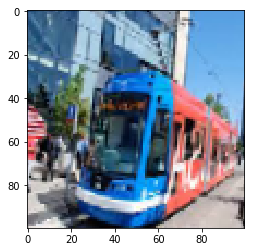

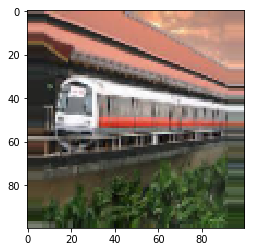

In [21]:
# https://keras.io/preprocessing/image/#imagedatagenerator-class
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

img_height = img_width = 100
channels = 3

datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=5,
                            zoom_range=.2,
                            horizontal_flip=True)

# generate image data from the training set
generator = datagen.flow_from_directory(train_folder,
                                        color_mode='rgb',
                                        target_size=(img_height, img_width),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=True)

# display some images
x, y = next(generator)
plt.imshow(x[0])
plt.show()

x, y = next(generator)
plt.imshow(x[0])
plt.show()

## Baseline Model - 4-layer CNN from scratch

As a baseline, let's train a simple Convolutional Neural Network to do binary classification.

This will be trained from scratch and compared against the transfer learning model(s).

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation,\
    BatchNormalization, Flatten, Dense

model = Sequential()

# Convolutional Block 1
# depth 8, kernel 3, stride 1, with padding
# input shape: 100, 100, 3 
# output shape (of the block): 33, 33, 8
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same',
                 activation='relu',
                 input_shape=(img_width, img_height, channels)))
# Note: input_shape is inferred for subsequent layers
model.add(MaxPool2D(pool_size=(3,3)))

# Convolutional Block 2
# depth 16, kernel 3, stride 1, with padding
# input shape: 33, 33, 8 
# output shape (of the block): 16, 16, 16
# Note: Batch norm is inserted before activation for 2nd conv block onwards
#       Batch Norm removes noise in the covariates (means, variances)
#       when we stack convolutional blocks
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 3
# depth 32, kernel 3, stride 1, with padding
# input shape: 16, 16, 16
# output shape (of the block): 8, 8, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 4
# depth 32, kernel 3, stride 1, with padding
# input shape: 8, 8, 32
# output shape (of the block): 4, 4, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Binary classifier
# input shape: 4, 4, 32
# output shape: 1
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
__________

### TensorBoard - Monitoring Training Progress

This is the first time we're training neural networks in keras.
- We'll be using the default backend of keras, which is Tensorflow.
- Therefore, we can use [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) to view training progress and metrics.

TensorBoard is already included in Tensorflow, so there is no separate installation required.

### Launching TensorBoard

#### Windows
Launch a new Anaconda prompt:

```
activate mldds03
cd \path\to\mldds-courseware\03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

#### MacOS / Ubuntu
Launch a new terminal:

```
source activate mldds03
cd /path/to/mldds-courseware/03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

### Viewing TensorBoard

Once you see TensorBoard launched, you can navigate to http://localhost:8008

In [27]:
from keras.callbacks import TensorBoard
import time

batch_size=1 # feel free to increase this if you have more images

train_generator = datagen.flow_from_directory(train_folder,
                                              color_mode='rgb',
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)

# make a unique log index so that it's easier to filter
# by training sessions
log_index = int(time.time())

# we set histogram_freq=0 because we are using a generator
tensorboard = TensorBoard(log_dir='./logs/baseline_cnn/%s' % log_index,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,
                    n_train_set//batch_size,
                    epochs=4,
                    callbacks=[tensorboard])

Found 26 images belonging to 2 classes.
Epoch 1/4
29/29 [==============================] - 1s 46ms/step - loss: 0.2967 - acc: 0.8276
Epoch 2/4
29/29 [==============================] - 1s 29ms/step - loss: 0.1588 - acc: 0.9655
Epoch 3/4
29/29 [==============================] - 1s 32ms/step - loss: 0.1107 - acc: 0.9655
Epoch 4/4
29/29 [==============================] - 1s 26ms/step - loss: 0.1397 - acc: 0.9310


You can view training progress from Tensorboard by going to http://localhost:8008

![tensorboard](assets/transfer/tensorboard-demo.png)

## Exercise - Classification Model Validation
 
1. Create a test_generator using datagen.flow_from_directory, but point it to the validation folder and set batch_size to all available test samples
```
test_generator = datagen.flow_from_directory(val_folder,
                                                color_mode='rgb',
                                                target_size=(img_height, img_width),
                                                batch_size=n_val_set,
                                                class_mode='binary',
                                                shuffle=False)
test_x, test_y = next(test_generator)
```

2. Run predictions using the CNN we just trained
```
pred_y = model.predict(test_x)
```
3. The predictions from the CNN are continuous values, so we need to convert them to binary
```
pred_y = np.where(pred_y > 0.5, 1, 0)
```
4. Use sklearn.metrics to evaluate the classification model (using confusion_matrix, classification_report).


### Setup

You may need to install sklearn into your conda environment.

```
conda install scikit-learn
```

In [44]:
# Your code here
from sklearn.metrics import confusion_matrix, classification_report

test_generator = datagen.flow_from_directory(val_folder,
                                             color_mode='rgb',
                                             target_size=(img_height, img_width),
                                             batch_size=n_val_set,
                                             class_mode='binary',
                                             shuffle=False)

test_x, test_y = next(test_generator)

pred_y = model.predict(test_x)
pred_y = np.where(pred_y > 0.5, 1, 0)

print(classification_report(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Found 10 images belonging to 2 classes.
             precision    recall  f1-score   support

        0.0       0.67      0.80      0.73         5
        1.0       0.75      0.60      0.67         5

avg / total       0.71      0.70      0.70        10

[[4 1]
 [2 3]]


## Transfer Learning with ImageNet VGG16

Now that we have our baseline CNN, let's try transfer learning. 

3 Steps:
1. Run the original VGG16 model to get VGG16's baseline
2. Freeze and retrain a classifier on top of VGG16
3. Un-freeze and fine-tune the model we got from step 2

## Reading List

|Material|Read it for|URL|
|--|--|--|
|A Survey on Transfer Learning (IEEE)|Overview of transfer learning|http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf|
|Transductive Learning: Motivation, Model, Algorithms|Explanation of Induction vs. Transduction Transfer Learning|http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2527.pdf|
|Supervised and Unsupervised Transfer Learning for Question Answering (Paper)|More unique application of transfer learning|https://arxiv.org/abs/1711.05345|